# Wrangling the Data

Real world data has problems. The most obvious, that we have seen multiple times so far is the presence of missing or incomplete data. Invalid or innaccurate data is a somewhat less common and much harder to detect problem (as we have discussed before we need to approach rejecting data with great caution). 

We will take this class to discuss a broad approach to data and cover some common problems that come up for various types of data. We will end with an introduction to dealing with images.

## Formatting the Data

Putting aside the issue of Big Data (data that is so large that it cannot be loaded into a pandas.DataFrame all at once), the main goal in formatting the data is to set it up so that it can be represented by a pandas.DataFrame structure. Most of the examples we have seen in class have been delivered as CSV files that are ready to be read into a dataframe. The primary exceptions so far have been the Berlin Airbnb data that arrived as multiple cross referenced CSV files, and the image recognition example whose data was a collection of JPG files.

We will consider the Airbnb data:

In [144]:
import numpy as np
import pandas as pa
import seaborn as sn

In [145]:
# First we get a link from drop box
# https://www.dropbox.com/s/lqin9zpgfwyt924/calendar_summary.csv?dl=0

# The trick here is that the last digit 'dl=0' needs to be changed to 'dl=1' and then 
# we just feed it into pandas.read_csv as we have above.

# This takes a while - it is downloading the information and then processing it, and it is more data
# than our other examples have used.

calendar = pa.read_csv('https://www.dropbox.com/s/lqin9zpgfwyt924/calendar_summary.csv?dl=1')
listings_sum = pa.read_csv('https://www.dropbox.com/s/5noljx9qipcyyul/listings_summary.csv?dl=1')
listings = pa.read_csv('https://www.dropbox.com/s/xtkx018qxjfjlah/listings.csv?dl=1')
neighborhoods = pa.read_csv('https://www.dropbox.com/s/rfqozggf5f2kzlu/neighbourhoods.csv?dl=1')
reviews_sum = pa.read_csv('https://www.dropbox.com/s/o8gvfm708g1cocf/reviews_summary.csv?dl=1')
reviews = pa.read_csv('https://www.dropbox.com/s/8dfu8qyc6n6cw3p/reviews.csv?dl=1')

In [146]:
listings.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
22547,29856708,Cozy Apartment right in the center of Berlin,87555909,Ulisses,Mitte,Brunnenstr. Süd,52.533865,13.400731,Entire home/apt,60,2,0,NaN,NaN,1,314
22548,29857108,Altbau/ Schöneberger Kiez / Schlafsofa,67537363,Jörg,Tempelhof - Schöneberg,Schöneberg-Nord,52.496211,13.341738,Shared room,20,1,0,NaN,NaN,6,78
22549,29864272,Artists loft with garden in the center of Berlin,3146923,Martin,Pankow,Prenzlauer Berg Südwest,52.531800,13.411999,Entire home/apt,85,3,0,NaN,NaN,2,15
22550,29866805,Room for two with private shower / WC,36961901,Arte Luise,Mitte,Alexanderplatz,52.520802,13.378688,Private room,99,1,0,NaN,NaN,3,6
22551,29867352,"Sunny, modern and cozy flat in Berlin Neukölln :)",177464875,Sebastian,Neukölln,Schillerpromenade,52.473762,13.424447,Private room,45,5,0,NaN,NaN,1,21


In [147]:
# There are many entries in Calendar.price that are NaN. It is not clear what that means
calendar = calendar[pa.notna(calendar.price)]

# Given an listing_id we get when it was booked and for what price
calendar[calendar.listing_id==29857108].head()

,listing_id,date,available,price
8212563,29857108,2019-02-04,t,$17.00
8212564,29857108,2019-02-03,t,$17.00
8212565,29857108,2019-02-02,t,$18.00
8212566,29857108,2019-02-01,t,$18.00
8212567,29857108,2019-01-31,t,$17.00


In [148]:
# For each list we could compute the mean of its price. When you first do it, you get an error
# because the price has been read as a string.

# So first we need to convert these strings to floats/integers
# The first character is '$' so we skip that one;
# Some of them also contain ',' if they are in the thousands in price.
np.mean([float(x[1:].replace(',', '')) for x in calendar.price[calendar.listing_id==29857108]])

17.141025641025642

In [149]:
# Let's go through the listing data and add the mean price for each listing:

for x in listings.index:
    bookings = calendar.price[calendar.listing_id==listings.loc[x, 'id']]
    listings.loc[x, 'mean_price'] = np.mean(
        [float(x[1:].replace(',', '')) for x in bookings])
    listings.loc[x, 'number_of_bookings'] = len(bookings)
    
# I'm going to ignore the warning that comes up. The way to fix it is to checking that bookings
# is not empty beroe passing it to the next two statements.

/anaconda3/envs/jupyterlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/jupyterlab/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [150]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,mean_price,number_of_bookings
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141,81.900709,141.0
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0,NaN,0.0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220,90.000000,220.0
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297,27.131313,297.0
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26,44.384615,26.0


In [151]:
# We should drop the listings that had no bookings, for one thing their price is obviously not telling us 
# something real (Lesson #1 from Pawn Stars)

listings = listings[listings.number_of_bookings!=0]

So to recap in this example we have shown the following *Data Wrangling* techniques:

- Cross referencing one dataframe with another
- Unpacking a number represented as a string using some of the string tools from Python
- Computing a new feature from other data
- Removing NaN values

What could we do with this new information. Consider the neighborhoods, what is the mean price in each neighborhood.

In [152]:
# Make a list of all the neighborhoods (note that the data gave us a list, but it is safer to take the
# actual values from the feature). Though to be super careful we should take some time to check 
# that they have been coded correctly.

# I pass it through set to eliminate duplicates, then I convert it to a data frame
nbhds = pa.DataFrame(set(listings.neighbourhood), columns = ['Neighbourhood'])
nbhds.head()

,Neighbourhood
0,Fennpfuhl
1,Karl-Marx-Allee-Nord
2,Friedrichsfelde Süd
3,Karlshorst
4,Altglienicke


In [153]:
# now for each neighborhood compute the mean and standard deviation of the price paid
# Note that this means we have to unpack the mean price we computed for each booking by the number
# of booksings; we will also need the total number of bookings for each neighborhood.
save = []

for x in nbhds.index:
    nbook = []
    xlist = listings.id[listings.neighbourhood==nbhds.loc[x, 'Neighbourhood']]
    for l in xlist:
        bookings_price = calendar.price[calendar.listing_id==l]
        bookings = [float(x[1:].replace(',', '')) for x in bookings_price]
        nbook += bookings
       
    nbhds.loc[x, 'bookings'] = len(nbook)
    nbhds.loc[x, 'mean_price'] = np.mean(nbook)
    nbhds.loc[x, 'sdv_price'] = np.std(nbook)
    nbhds.loc[x, 'median_price'] = np.median(nbook)
    if np.std(nbook)>np.mean(nbook):
        save += [nbook]
    
    
nbhds.tail()

,Neighbourhood,bookings,mean_price,sdv_price,median_price
131,Falkenhagener Feld,1064.0,54.916353,40.630528,30.0
132,Alt-Hohenschönhausen Süd,4294.0,62.264322,45.059519,47.0
133,Buckow,1380.0,64.547101,22.026268,65.0
134,Helmholtzplatz,35101.0,130.613914,467.020025,70.0
135,Brunsbütteler Damm,2568.0,93.455997,125.612625,39.0


Note that there are some mismatches between mean and standard deviation. I have pulled out one of them so we can check on what is happening. What we see is that the distribution of prices in a neighborhood are not normal.

This is an example where Median and Percentiles may be a better notion of center and spread of the data

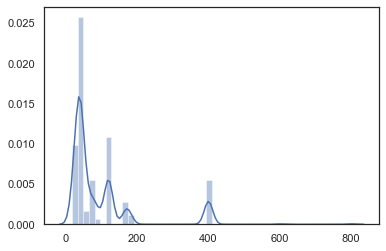

In [154]:
sn.distplot(save[0]);

## Dealing with Strings

Now we will consider some techniques for dealing with strings. Attached to the Berlin Airbnb data is a set of reviewer comments for eaching listing. Again we need to cross reference this list with the listing id.

In [155]:
import string

In [156]:
listingreview = reviews_sum.comments[reviews_sum.listing_id == 2015]
listingreview[0:5]

0    Mein Freund und ich hatten gute gemütliche vie...
1    Jan was very friendly and welcoming host! The ...
2    Un appartement tres bien situé dans un quartie...
3    It is really nice area, food, park, transport ...
4    Buena ubicación, el departamento no está orden...
Name: comments, dtype: object

A common technique is to count the frequency of words and look for patterns. It is somewhat more complicated in this case because of the various languages being used. 

In [157]:
# make a list of the all the reviews used in a listing. Note that I am also removing any punctuation.

words = []
for x in listingreview:
    words += x.translate(str.maketrans('', '', string.punctuation)).split()

In [158]:
words[100:105]  # One issue is that people misspell words - a lot!

['area', 'is', 'sooo', 'amazing', 'lots']

In [159]:
# We do not care so much about words with only a few letters, so lets drop them.

words2 = pa.DataFrame([x for x in words if len(x)>3])
words2.loc[:, 'count'] = 1 # Add a counter
words2[1000:1005]

,0,count
1000,near,1
1001,public,1
1002,transport,1
1003,restaurants,1
1004,about,1


In [160]:
# Use groupby to collect them and sum up the count;

# Then send it through .sort_values to bring the top responses to the top

word_freq = words2.groupby([0]).sum().sort_values(by=['count'], ascending = False)
word_freq.head(10)

,count
0,
very,49
apartment,39
Berlin,34
location,30
sehr,30
stay,29
great,27
place,26
with,26


In [165]:
# We could make a function to produce the word frequency from a listing_id.

def word_freq(id):
    listingreview = reviews_sum.comments[reviews_sum.listing_id == id]
    words = []
    for x in listingreview:
        words += x.translate(str.maketrans('', '', string.punctuation)).split()
    words2 = pa.DataFrame([x for x in words if len(x)>3])
    words2.loc[:, 'count'] = 1 # Add a counter 
    
    temp = words2.groupby([0]).sum().sort_values(by=['count'], ascending = False)
    total = sum(temp.loc[:, 'count'])
    for x in temp.index:
        temp.loc[x, 'freq'] = temp.loc[x, 'count'] / total
        
    return temp

In [166]:
id = 3309
print('Mean Price for this listing: {}'.format(listings.mean_price[listings.id == id].iloc[0]))
word_freq(id).head(10)

Mean Price for this listing: 27.13131313131313


,count,freq
0,,
Jana,25,0.019395
with,16,0.012413
Berlin,14,0.010861
very,13,0.010085
stay,11,0.008534
place,11,0.008534
room,11,0.008534
there,10,0.007758
Yana,9,0.006982


In [167]:
id = 3176
print('Mean Price for this listing: {}'.format(listings.mean_price[listings.id == id].iloc[0]))
word_freq(id).head(10)

Mean Price for this listing: 90.0


,count,freq
0,,
very,98,0.019003
apartment,97,0.018809
great,93,0.018034
with,80,0.015513
Berlin,78,0.015125
Britta,74,0.014349
stay,71,0.013768
flat,70,0.013574
location,56,0.010859


One problem you might notice if you do this enough is that not all listings have review comments.

- What could we do from here?
- What ideas do you have for dealing with the multiple languages?

## Dealing with Categorical Data

There are couple of techniques for working with categorical data you should be aware of. The major issue is that the algorithms in scikitlearn have been designed to work on categorical data represented as integers. This makes sense because the authors of the algorithms do not know what your categories are.

### Binary Data
The simplest case is a categorical variable that takes on only two values. These we can safetely code as a $0$ or $1$; or $-1$ or $1$ if that makes more sense for the problem.

In [168]:
# Consider the following dataset about homes that sold in a city in Iowa

hd = pa.read_csv('Data Sets/house-prices/train.csv')

hd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [169]:
# For example the Street feature takes only two values
set(hd.Street)

{'Grvl', 'Pave'}

In [170]:
# We can recode it using a dictionary and .map()
Street_dict = {'Grvl':0, 'Pave':1, 0:0, 1:1}  
# Note we include the trivial coding of the new values as otherwise if we run this twice
# it produces NaN values for the Street feature.
hd.Street = hd.Street.map(Street_dict)
set(hd.Street)

{0, 1}

### Non Binary Data

Categorical data could be ordered or unordered. It is tempting to to take ordered data and code it as 0, 1, 2, 3. However we need ot be careful. Consider the following examples:

In [36]:
set(hd.Alley)

{'Grvl', 'Pave', nan}

nan in this case almost certainly means that the house does not have an Alley. Note that we could recode this feature as: 'Pave' = 1; 'Grvl'=0.5; and nan=0. 

However this implies that the difference between No Alley and a Gravel Alley is equal to the difference beetween a Gravel Alley and a Paved Alley, and we really have no way of judging that.

The way to deal with these non-binary cases is to use what is called *One Hot Encoding*. We create three new features:  Alley_Grvl, Alley_Pave, and Alley_nan and then code them each as a 1 if the Alley feature has that value and a 0 otherwise. Here is a code snippet One Hot Encoding a feature.

In [46]:
def onehot(df, feature):
    '''A function to do one-hot-encoding of a feature from a dataframe. df = dataframe'''

    v = list(set(df[feature])) # Make an iterable of the unique values for the feature
    
    for c in df.index: # cycle through the samples
        t = df.loc[c, feature]
        
        for test in v:
            if pa.isna(test):  # nan values are sort of a problem and have to be handled separately
                if pa.isna(t):
                    df.loc[c, '{}_nan'.format(feature)] = 1
                else:
                    df.loc[c, '{}_nan'.format(feature)] = 0
            else:
                if t == test:
                    df.loc[c, '{}_{}'.format(feature, test)] = 1  # Makes a new feature with name feature_value
                                                              # and codes it as a 1 if that was the value
                else:
                    df.loc[c, '{}_{}'.format(feature, test)] = 0  # and 0 otherwise
            
    return df.drop(feature, axis=1) # returns a dataframe with the encoded feature removed

In [47]:
hd2 = onehot(hd, 'Alley')
hd2[30:40]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Alley_nan,Alley_Pave,Alley_Grvl
30,31,70,C (all),50.0,8500,1,Reg,Lvl,AllPub,Inside,...,NaN,0,7,2008,WD,Normal,40000,0.0,1.0,0.0
31,32,20,RL,NaN,8544,1,IR1,Lvl,AllPub,CulDSac,...,NaN,0,6,2008,WD,Normal,149350,1.0,0.0,0.0
32,33,20,RL,85.0,11049,1,Reg,Lvl,AllPub,Corner,...,NaN,0,1,2008,WD,Normal,179900,1.0,0.0,0.0
33,34,20,RL,70.0,10552,1,IR1,Lvl,AllPub,Inside,...,NaN,0,4,2010,WD,Normal,165500,1.0,0.0,0.0
34,35,120,RL,60.0,7313,1,Reg,Lvl,AllPub,Inside,...,NaN,0,8,2007,WD,Normal,277500,1.0,0.0,0.0
35,36,60,RL,108.0,13418,1,Reg,Lvl,AllPub,Inside,...,NaN,0,9,2006,WD,Normal,309000,1.0,0.0,0.0
36,37,20,RL,112.0,10859,1,Reg,Lvl,AllPub,Corner,...,NaN,0,6,2009,WD,Normal,145000,1.0,0.0,0.0
37,38,20,RL,74.0,8532,1,Reg,Lvl,AllPub,Inside,...,NaN,0,10,2009,WD,Normal,153000,1.0,0.0,0.0
38,39,20,RL,68.0,7922,1,Reg,Lvl,AllPub,Inside,...,NaN,0,1,2010,WD,Abnorml,109000,1.0,0.0,0.0
39,40,90,RL,65.0,6040,1,Reg,Lvl,AllPub,Inside,...,NaN,0,6,2008,WD,AdjLand,82000,1.0,0.0,0.0


In [48]:
set(hd.ExterQual)

{'Ex', 'Fa', 'Gd', 'TA'}

For the Exterior Quality feature (and the other Quality features) there is a clear order to the values, but again what is not clear is if the distance between *Excellent* and *Good* is the same as the distance between *Good* and *Fair*. It is maybe not a bad assumption for these features, but might be one worth checking.

**What do I mean by Checking?** Develop a model using each encoding method and see what the effect on the errors is.

In [49]:
hd3 = onehot(hd2, 'ExterQual')

So notice what this means now: We can now produce a matrix with numerical entries that correspond to the categorical variables. So just with these two, plus the existing numerical features we have.

In [79]:
keep = ['LotArea', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'SalePrice', 
      'Alley_nan', 'Alley_Pave', 'Alley_Grvl', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterQual_Ex']
hd4 = hd3.loc[:, keep]
hd4.head()

,LotArea,1stFlrSF,2ndFlrSF,BedroomAbvGr,FullBath,HalfBath,SalePrice,Alley_nan,Alley_Pave,Alley_Grvl,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_Ex
0,8450,856,854,3,2,1,208500,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9600,1262,0,3,2,0,181500,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11250,920,866,3,2,1,223500,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9550,961,756,3,1,0,140000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,14260,1145,1053,4,2,1,250000,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
# Convert them to Numpy Arrays X for predictors and y for result

keep.remove('SalePrice')
X = np.array(hd4.loc[:, keep])
y = np.array(hd4.loc[:, 'SalePrice'])

In [81]:
import numpy.random as rn
from sklearn.linear_model import LinearRegression

In [82]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [83]:
reg = LinearRegression().fit(X_train, y_train)

In [84]:
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Training R2: 0.7209700397004002
Testing R2: 0.7611481246736456


### Including Additional Features Gives a Better Prediction

So rarely does this work as well as it did for me here, but sometimes (**not always**) including additional features improves our model. In this case we get a significant improvement in the $R^2$ value.

In [87]:
# What if we did not use the categorical variables we included and just the numerical ones

reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)
print('Training R2: {}'.format(reg2.score(X_train[:, 0:6], y_train)))
print('Testing R2: {}'.format(reg2.score(X_test[:, 0:6], y_test)))

Training R2: 0.6354505696652195
Testing R2: 0.6577133740297065


That said. How important are the categorical features here in the model. We can check that by checking the value of their coeeficients:

In [121]:
coef = np.concatenate( (reg.coef_.reshape(1, 13), np.concatenate( (reg2.coef_, [0]*7) ).reshape(1, 13) ), 
               axis = 0)
coef_df = pa.DataFrame(coef, index = ['reg', 'reg2'], columns = keep)
coef_df
# I use a pandas.DataFrame here because it lets me line up the names of the features with the values

,LotArea,1stFlrSF,2ndFlrSF,BedroomAbvGr,FullBath,HalfBath,Alley_nan,Alley_Pave,Alley_Grvl,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_Ex
reg,0.464494,96.062834,53.394568,-10095.855253,13854.469869,14961.260357,12176.812927,-2915.993635,-9260.819292,-65185.742197,13543.467385,-33373.883105,85016.157917
reg2,0.295196,125.820689,60.660207,-21107.421317,33282.672347,27410.744899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The parameters for the model with categorical variables are significant. Note that the negative values mean that these features subtract from the value and the positive values add to them.

For example Exterior Quality *Typical/Average* is a negative; and Exterior Quality *Fair* is a negative.

But notice the interesting thing we learn:  *Alley Missing* is a positive, and *Alley Paved* and *Alley Gravel* are both negatives. This means our naive idea of coding *Alley* as 0, 0.5, 1.0 would have completely led our model astray!

## Dealing with Missing Data

We have covered a number of examples where we made the decision to drop samples that had missing data. This is not always ideal, for example we may not have a large number of samples to begin with (which makes dividing the sample into testing / training sets problematic), we may have a large number of features and the sample with missing data may still have valuable information, and the sample might have unique values for some features that we need to make our model complete.

Some other ideas for dealing with missing data:
- Using regression to fill in missing data. If the data field that is misisng is numerical we could use one of our regression techniques to compute an estimate for the missing value.
- Using categorization to fill in misssing data. If the data field that is missing is categorical we could use one of our categorization techniques to compute an estimate for the missing value.
- Using "Missing" as a category. If the data field that is missing is categorical, particularly if there are many missing it, we could use "Missing" or "NaN" as a value. In some cases (like surveys) this may even provide accurate information as sometimes no response is a response. (note the example above with *Alley Missing*)
- Dropping the feature. An alternative to dropping samples is to drop the feature. This might be the right decision if you have plenty of other features, if it appears some other features are related to this one, and if there are many samples missing this feature.
- Separating the analysis. Finally you could run the analysis separately for samples missing this feature. 

In all of these cases what you could do is develop models with different methods of dealing with missing data and then check the error on a testing set.

## Dealing with Images

Finally I want add a bit about how we deal with images. Images ultimately are represented (for the purposes of this class) as values for the color or intensity of a pixel. As such they are essentially **VERY** large vectors. In fact Python easily lets us read in PNG images as a vector and can handle other image file types with some extra work.

In [133]:
import matplotlib.pyplot as plt
from matplotlib.image import imread # We need the imread function from matplotlib.image

In [140]:
img = imread('Images/2.4.png')
img.shape

(576, 720, 4)

matplotlib.image.imread has read in the image as a set of 4 matrices of size 576x720 (these four are the Cyan-Magenta-Yellow-Black (CMYK) component colors). These four matrices are the four colors. What we could do to think about this as a sample for a dataframe is flatten it to just a single row vector of size

In [171]:
576*720*4

1658880

Samples in these cases would be different images, and the features would be the values for the pixes. Note that this means we expect to have a DataFrame with many features. However one thing to realize is that there will be correlations between those features (if a pixel is a particular color, there is a strong possibility that nearby pixels are the same or a close color).

# Resampling

Remember that our goal is to estimate and assess the quality of our models. We have seen that dividing the data set into training / testing allows us to develop a model and then estimate the accuracy of the model. However just doing this once is unsatasfactory. You may have noticed for example that if you rerun this process you get different results for the model and for its testing and training error. 

Recall that *overfitting* is when the model fits the irreducible error and may lead to large errors on new data.

The goal is understanding the potential error of our model. That means more than just finding the model that produces the best result on our testing set. We want to understand for example:

- the potential of our model to vary as the training data changes; high dependence on the training data is an indicator of overfitting.
- the variation of the error of the model applied to new data; an error estimate is of little utility if it is not accompanied by an understanding of the expected spread of that error.

Note the problem though, we have (usually) a limited amount of data to work with. Sop we need some techniques for developing our model on different training sets and seeing how it changes. 

## Cross Validation

The first method is for cross validation. It is essentially the same as the Training / Testing division of the dataset that we've used, except that the division is repeated, the model retrained, and the error recomputed for multiple divisions into training and testing sets. Here is an example where we repeat the process five times, using 20% of the data each time as a testing set. Note that the only randomness is the initial ordering of the dataset, and so this means that each sample is included in one of the testing sets and in four of the training sets. This will give us a sense of how our model depends on the training sets, and how the testing set error varies.

We will apply it to the two housing price datasets above (the one with and the one without the *One-Hot Encoded* categorical data.

In [201]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
R2 = pa.DataFrame( np.array([ [0]*5, [0]*5, [0]*5, [0]*5]).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])
# Making a DataFrame to record the R2 values in

for k in range(5):
    X_test = X[k*test:(k+1)*test]       # Then create the test
    y_test = y[k*test:(k+1)*test]
    X_train = np.concatenate( (X[:k*test], X[(k+1)*test:]), axis=0)     # and train sets
    y_train = np.concatenate( (y[:k*test], y[(k+1)*test:]), axis=0)
    reg = LinearRegression().fit(X_train, y_train)
    reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)
    
    R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
    R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
    R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
    R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

R2mean = [0]*4
R2std = [0]*4
for c in range(4):
    R2mean[c] = np.mean(R2.iloc[0:5, c])
    R2std[c] = np.std(R2.iloc[0:5, c])
    
R2 = R2.append( pa.Series(R2mean, index=R2.columns), ignore_index=True )
R2 = R2.append( pa.Series(R2std, index=R2.columns), ignore_index=True)
R2.index = [0, 1, 2, 3, 4, 'Mean', 'Standard Deviation']
R2

,train_1,test_1,train_2,test_2
0,0.712887,0.789077,0.626812,0.688939
1,0.752681,0.651841,0.658249,0.582049
2,0.719999,0.769031,0.635358,0.657974
3,0.710820,0.803929,0.620461,0.721462
4,0.762766,0.530331,0.670594,0.455789
Mean,0.731831,0.708842,0.642295,0.621243
Standard Deviation,0.021596,0.104132,0.019079,0.094749


If you run this code snippet multiple times you will see that in the samples 0 to 4 there is significant variation in the R2 values; however the mean of the five samples varies much less. We can now conclude with some confidence that the model developed including the *Alley* and *Exterior Quality* categorical variables is more accurate.

## Bootstraps

In some cases we would like to have even more runs of our model and comparisons with training and testing sets. A bootstrap of a sample is a random sampling, with replacement, of the dataset of the same size as the dataset. With replacement menas that as we construct the boostrap, we select samples to include, but then we add them back to the dataset to possibly be selected again. As the bootsrap is the same size as the dataset, this means that we expect to have some samples repeated in the bootstrap, and we also expect there to be some samples from the dataset that are missed. We then run the bootstrapping multiple times, and these two features will give us a sense of  how sensitive the model is to variations in the training data.

What makes the bootstrap so powerful is that with even a moderately sized dataset it gives a method of generating large numbers of training/testing sets on which to apply the model.

In [230]:
num = 40 # number of bootstraps to use
Xboot = [0]*num
yboot = [0]*num

n = X.shape[0]
for k in range(num):
    sample = np.random.randint(0, n, n)  # Note here starting with a random permutation is not necessary
    Xboot[k] = X[sample, :]
    yboot[k] = y[sample]

In [231]:
test = int(0.20*n)
R2 = pa.DataFrame( np.array([ [0]*num]*4).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])

for k in range(num):
    X_test = Xboot[k][:test]
    y_test = yboot[k][:test]
    X_train = Xboot[k][test:]
    y_train = yboot[k][test:]
    reg = LinearRegression().fit(X_train, y_train)
    reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)
    
    R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
    R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
    R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
    R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)
    
R2mean = [0]*4
R2std = [0]*4
for c in range(4):
    R2mean[c] = np.mean(R2.iloc[0:5, c])
    R2std[c] = np.std(R2.iloc[0:5, c])
    
R2 = R2.append( pa.Series(R2mean, index=R2.columns), ignore_index=True )
R2 = R2.append( pa.Series(R2std, index=R2.columns), ignore_index=True)
R2.index = list(range(num)) + ['Mean', 'Standard Deviation']
R2.tail(10)

,train_1,test_1,train_2,test_2
32,0.764452,0.358529,0.666273,0.240286
33,0.745942,0.787352,0.646507,0.720294
34,0.804870,0.520469,0.713266,0.415989
35,0.801805,0.815401,0.706977,0.728830
36,0.668247,0.661218,0.568120,0.547452
37,0.771404,0.761781,0.670898,0.678301
38,0.796123,0.775308,0.716720,0.685650
39,0.795410,0.843035,0.701445,0.750313
Mean,0.725578,0.720350,0.636225,0.613854
Standard Deviation,0.044522,0.090323,0.051553,0.082573
